best_parameters= {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 1000, 'subsample': 0.75}
rmse_train= 17.856604691120452
rmse_test= 46.39452976992358
r2_train= 0.9999273478643519
r2_test= 0.9995078185357817


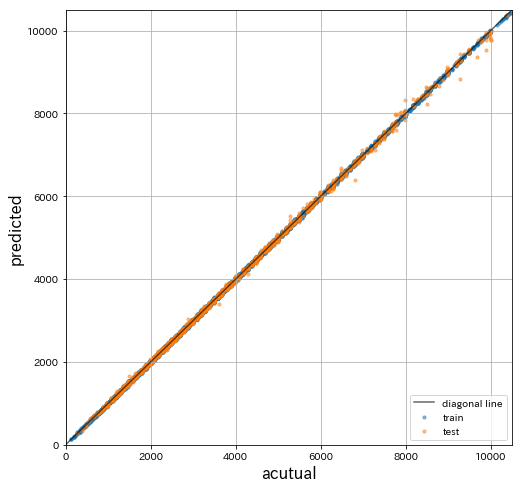

In [3]:
# libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split,GridSearchCV
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

class Learning:
    def __init__(self,data_version):
        self.data_version=data_version #学習させたいデータのversionを指定
        self.load_path='intermediate_data/preprocessed_spec_for_learning_{}.pickle'.format(self.data_version)
        self.model_version=self.data_version
        self.model_path='model/model_xgb_{}.pickle'.format(self.model_version)
        self.prediction_path='intermediate_data/prediction_xgboost_{}.pickle'.format(self.data_version)

    def load_prep_spec(self):
        with open(self.load_path,'rb') as f:
            spec=pickle.load(f)
        return spec
    
    def xgb_learning(self,spec):
        self.X = spec.drop('price', axis=1).as_matrix()
        self.y = spec['price']
        self.indices=spec.index

        #データをわける
        self.X_train, self.X_test, self.y_train, self.y_test, self.index_train,self.index_test = train_test_split(self.X, self.y,self.indices, test_size = 0.1, random_state = 666)
        
        params={'n_estimators':[1000],
                'learning_rate':[0.05], 
                'gamma':[0], 
                'subsample':[0.75],
                'colsample_bytree':[1], 
                'max_depth':[6] 
                }
        
        xgb_model=xgb.XGBRegressor()
        gs = GridSearchCV(xgb_model,params)
        gs.fit(self.X_train,self.y_train)
        
        return gs
    
    def show_results(self,gs):
        self.y_test_pred = gs.predict(self.X_test)
        self.y_train_pred =gs.predict(self.X_train)
        
        print('best_parameters=',gs.best_params_)
        print('rmse_train=',np.sqrt(mean_squared_error(self.y_train,self.y_train_pred)))
        print('rmse_test=',np.sqrt(mean_squared_error(self.y_test,self.y_test_pred)))
        print('r2_train=',r2_score(self.y_train,self.y_train_pred))
        print('r2_test=',r2_score(self.y_test,self.y_test_pred))

        u_lim=10500
        l_lim=0
        plt.figure(figsize=(8, 8))
        plt.plot([l_lim,u_lim], [l_lim,u_lim], c='k', alpha=0.6, label = 'diagonal line') # diagonal line
        plt.scatter(self.y_train,self.y_train_pred,label='train',alpha=0.5,s=10)
        plt.scatter(self.y_test,self.y_test_pred,label='test',alpha=0.5,s=10)
        plt.xlim(l_lim,u_lim)
        plt.ylim(l_lim,u_lim)
        plt.xlabel('acutual', fontsize=16)
        plt.ylabel('predicted', fontsize=16)
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()
        
    def save_model(self,gs):
        with open(self.model_path,'wb') as f:
            pickle.dump(gs, f)
    
    def check_prediction(self,spec):
        dif_train=abs(self.y_train_pred-self.y_train)
        dif_test=abs(self.y_test_pred-self.y_test)
        bad_pred_train=dif_train[dif_train>500]
        bad_pred_test=dif_test[dif_test>500]
        bad_index=list(bad_pred_train.index)
        bad_index.extend(list(bad_pred_test.index))
        spec_bad_pred=spec.loc[bad_index,:]        

        for col in spec_bad_pred:
            fig, ax1 = plt.subplots()
            ax1.hist(spec_bad_pred[col],bins=100,color='blue', alpha=0.5)
            ax2 = ax1.twinx()  # 2つのプロットを関連付ける
            ax2.hist(spec[col],bins=100,color='red', alpha=0.5)
            plt.title(col)
            plt.show()
 
        index=list(self.index_train)
        index.extend(list(self.index_test))
        prediction=list(self.y_train_pred)
        prediction.extend(list(self.y_test_pred))
        spec_pred=pd.DataFrame()
        spec_pred['index']=index
        spec_pred['prediction']=prediction
        spec_pred=spec_pred.set_index('index')
        spec_all=spec_pred.join(spec)
        spec_bad=spec_all.loc[bad_index,:]
        return spec_all,spec_bad

    def save_prediction(self,spec_all):
        with open(self.prediction_path,'wb') as f:
            pickle.dump(spec_all, f)

if __name__ == '__main__':
    data_version='original'
    learning=Learning(data_version)
    spec=learning.load_prep_spec()
    gs=learning.xgb_learning(spec)
    learning.show_results(gs)
    learning.save_model(gs)
#     spec_all,spec_bad=learning.check_prediction(spec)
#     learning.save_prediction(spec_all)